In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

data_path = "/content/drive/MyDrive/artExtract.csv"
dataset = pd.read_csv(data_path)
dataset.head()

uuid  \
0  00007f61-4922-417b-8f27-893ea328206c   
1  0000bd8c-39de-4453-b55d-5e28a9beed38   
2  0001668a-dd1c-48e8-9267-b6d1697d43c8   
3  00032658-8a7a-44e3-8bb8-df8c172f521d   
4  0003d4e4-d7fd-4835-8d27-1e9e20672e39   

                                             iiifurl  \
0  https://api.nga.gov/iiif/00007f61-4922-417b-8f...   
1  https://api.nga.gov/iiif/0000bd8c-39de-4453-b5...   
2  https://api.nga.gov/iiif/0001668a-dd1c-48e8-92...   
3  https://api.nga.gov/iiif/00032658-8a7a-44e3-8b...   
4  https://api.nga.gov/iiif/0003d4e4-d7fd-4835-8d...   

                                        iiifthumburl viewtype  sequence  \
0  https://api.nga.gov/iiif/00007f61-4922-417b-8f...  primary         0   
1  https://api.nga.gov/iiif/0000bd8c-39de-4453-b5...  primary         0   
2  https://api.nga.gov/iiif/0001668a-dd1c-48e8-92...  primary         0   
3  https://api.nga.gov/iiif/00032658-8a7a-44e3-8b...  primary         0   
4  https://api.nga.gov/iiif/0003d4e4-d7fd-4835-8d...  primary         0   

   width  height  maxpixels                 created                modified  \
0   3365    4332        NaN  2013-07-05 15:41:08-04  2024-10-01 17:28:59-04   
1   3500    4688        NaN  2013-08-05 14:31:59-04  2024-10-01 17:29:07-04   
2   3446    4448        NaN  2014-01-02 14:50:50-05  2024-10-01 17:29:46-04   
3   2674    3798        NaN  2010-10-13 15:37:25-04  2024-10-01 17:33:38-04   
4   3000    2648      640.0  2014-11-19 14:24:42-05  2024-10-01 17:27:38-04   

   depictstmsobjectid assistivetext  
0               17387           NaN  
1               19245           NaN  
2               23830           NaN  
3                 713           NaN  
4               71457           NaN

In [ ]:
import pandas as pd
import requests
from io import BytesIO
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import os
from tqdm import tqdm  # Import tqdm for the progress bar

# Load the dataset (replace 'your_dataset.csv' with your actual dataset path)

df = pd.read_csv(data_path)

# Take a random 10% sample of the dataset
df = df.sample(frac=0.05, random_state=42).reset_index(drop=True)

# Load pre-trained ResNet model for feature extraction
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the final classification layer
model.eval()  # Set model to evaluation mode

# Define image transformations (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create a directory to store downloaded images if it doesn't exist
if not os.path.exists("images"):
    os.makedirs("images")

# Function to download and preprocess images from URLs
def download_and_preprocess_image(url, image_id):
    try:
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        image_path = f"images/{image_id}.jpg"
        image.save(image_path)
        return image_path
    except Exception as e:
        print(f"Error downloading or processing image {image_id}: {e}")
        return None

# Function to extract features from an image
def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(image).squeeze().numpy()
    return features

# Iterate through the 10% sample, download images, extract features, and save them
image_features = {}
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing images", ncols=100):
    image_id = row['uuid']
    image_url = row['iiifthumburl']  # URL of the thumbnail image

    # Download and preprocess the image
    image_path = download_and_preprocess_image(image_url, image_id)
    if image_path:
        # Extract and store features
        features = extract_features(image_path)
        image_features[image_id] = features

# Save features to a file for future use (e.g., as a NumPy file)
np.save("image_features.npy", image_features)

print("Image processing and feature extraction completed!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Processing images:  40%|████████████████                        | 2458/6121 [29:46<39:40,  1.54it/s]

Error downloading or processing image 6c195ce6-84b0-40c1-9158-4d9ffc684716: Response ended prematurely


Processing images:  44%|█████████████████▋                      | 2701/6121 [32:35<29:25,  1.94it/s]

Error downloading or processing image 48fa4e17-6473-41a6-a036-17240372b6b0: Response ended prematurely


Processing images:  46%|██████████████████▎                     | 2810/6121 [33:54<50:01,  1.10it/s]

Error downloading or processing image 3ddad65f-fe6f-4f5a-95ce-b658589bbb78: Response ended prematurely


Processing images:  61%|████████████████████████▎               | 3718/6121 [45:17<22:24,  1.79it/s]

Error downloading or processing image 8d8b827a-9cad-4dcf-a529-8abb011ec650: Response ended prematurely


Processing images:  65%|█████████████████████████▉              | 3974/6121 [48:29<23:44,  1.51it/s]

Error downloading or processing image c0b5510b-5433-4917-9e9b-c5d94344706f: Response ended prematurely


Processing images:  69%|███████████████████████████▌            | 4219/6121 [51:35<19:20,  1.64it/s]

Error downloading or processing image c56f1a43-03e1-49be-8994-bc33ead63c6e: Response ended prematurely


Processing images:  80%|███████████████████████████████▉        | 4878/6121 [59:39<16:38,  1.24it/s]

Error downloading or processing image fd4e2e2f-0691-4af1-a87c-5d4cb7fb5584: Response ended prematurely


Processing images:  88%|█████████████████████████████████▍    | 5395/6121 [1:05:57<07:47,  1.55it/s]

Error downloading or processing image ecd9037f-a4bb-4529-9d3e-bb6eef2e4c07: Response ended prematurely


Processing images:  98%|█████████████████████████████████████▏| 5993/6121 [1:13:17<02:13,  1.05s/it]

Error downloading or processing image 6914c681-5e77-49cf-9672-4ed464881dff: Response ended prematurely


Processing images: 100%|██████████████████████████████████████| 6121/6121 [1:14:56<00:00,  1.36it/s]

Image processing and feature extraction completed!


In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load saved image features
image_features = np.load("image_features.npy", allow_pickle=True).item()  # Load as dictionary

# Convert image feature dictionary to an array
X = np.array(list(image_features.values()))

# Perform KMeans clustering (let's try 5 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X)

# Display clustering results
for idx, cluster in enumerate(clusters):
    print(f"Image ID: {list(image_features.keys())[idx]}, Cluster: {cluster}")


Streaming output truncated to the last 5000 lines.
Image ID: 87f22061-0a91-456b-b63a-31d2b77ef5af, Cluster: 0
Image ID: 6f5c291b-5e9e-4f9b-9b71-b500d224cb40, Cluster: 0
Image ID: 0dce60b6-8dc1-4f12-9507-053c80c44db5, Cluster: 0
Image ID: 0c602080-7be6-4967-b482-591f385d911b, Cluster: 1
Image ID: 95800f79-6b5e-4299-987c-f1529772e17f, Cluster: 1
Image ID: 7554bf83-bc14-406e-95d9-87d33be78616, Cluster: 1
Image ID: 28671ebd-ef18-49ff-b757-e78ec7ab3a25, Cluster: 1
Image ID: 57686ed0-0ef1-4af0-9ef9-15959988b2b0, Cluster: 1
Image ID: e80afe9d-a324-4a2b-8821-26a4bb74b16b, Cluster: 1
Image ID: c191a56b-e4fd-48bf-9502-196561457faa, Cluster: 0
Image ID: f12d0651-6678-4854-950a-d410f9038db0, Cluster: 1
Image ID: dd350d6d-dce5-4a69-ae13-de6579aa4961, Cluster: 1
Image ID: 6a6b3bb6-7ab9-4c3e-8a5a-77e29556bd49, Cluster: 0
Image ID: 0543c934-8ac6-408e-9187-05db28f9921e, Cluster: 1
Image ID: 08592556-703a-45e7-a40a-a23abe0a569b, Cluster: 0
Image ID: 5e77c92f-ab90-4758-b6a6-89ea915c8194, Cluster: 1
Image

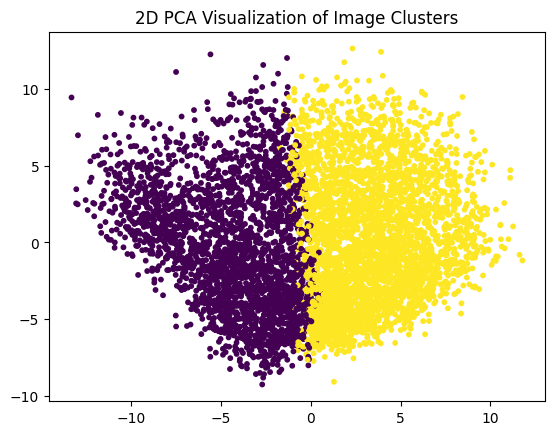

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot clusters in 2D (if you have unsupervised clusters)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=10)
plt.title("2D PCA Visualization of Image Clusters")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import random
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Load saved image features
image_features = np.load("image_features.npy", allow_pickle=True).item()

# Load dataset (replace 'your_dataset.csv' with actual path)
df = pd.read_csv(data_path)  # Replace with actual path

# Take a random 5% sample (to match feature extraction process)
df = df.sample(frac=0.05).reset_index(drop=True)

# Get all available image IDs that have extracted features
available_images = df[df['uuid'].isin(image_features.keys())]

# Ensure there are at least two images
if len(available_images) < 2:
    print("Not enough images with extracted features to compare.")
else:
    # Randomly select two image IDs
    selected_images = available_images.sample(2, random_state=42)  # Select 2 random images
    # image_id_1, image_id_2 = selected_images['uuid'].values
    # image_url_1, image_url_2 = selected_images['iiifthumburl'].values  # Get image URLs
    image_id_1 = 'd57307be-f4a4-4ee4-a7c7-8d2fa6a91010'
    image_id_2 = 'b0e9ed54-0d96-45ab-985d-4887d8920291'
    image_url_1 = 'https://api.nga.gov/iiif/d57307be-f4a4-4ee4-a7c7-8d2fa6a91010/full/!200,200/0/default.jpg'
    image_url_2 = 'https://api.nga.gov/iiif/b0e9ed54-0d96-45ab-985d-4887d8920291/full/!200,200/0/default.jpg'
    # Retrieve their features
    features_1 = image_features[image_id_1].reshape(1, -1)
    features_2 = image_features[image_id_2].reshape(1, -1)

    # Compute Cosine Similarity (higher means more similar)
    similarity = cosine_similarity(features_1, features_2)[0][0]

    # Compute Euclidean Distance (lower means more similar)
    euclidean_distance = np.linalg.norm(features_1 - features_2)

    # Download and open the images
    response_1 = requests.get(image_url_1)
    response_2 = requests.get(image_url_2)
    image_1 = Image.open(BytesIO(response_1.content))
    image_2 = Image.open(BytesIO(response_2.content))

    # Plot images side-by-side with similarity scores
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image_1)
    axes[0].axis('off')
    axes[0].set_title(f"Image 1: {image_id_1}")

    axes[1].imshow(image_2)
    axes[1].axis('off')
    axes[1].set_title(f"Image 2: {image_id_2}")

    # Add similarity metrics as a title
    plt.suptitle(f"Cosine Similarity: {similarity:.4f} | Euclidean Distance: {euclidean_distance:.4f}", fontsize=12, fontweight='bold')
    print(f"image id 1: {image_id_1} image_id_2 : {image_id_2}")
    print(f"image id 1: {image_url_1} image_id_2 : {image_url_2}")

    plt.show()


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7d626ebc2a20>

image id 1: b0e9ed54-0d96-45ab-985d-4887d8920291 image_id_2 : b0e9ed54-0d96-45ab-985d-4887d8920291
image id 1: https://api.nga.gov/iiif/b0e9ed54-0d96-45ab-985d-4887d8920291/full/!200,200/0/default.jpg image_id_2 : https://api.nga.gov/iiif/b0e9ed54-0d96-45ab-985d-4887d8920291/full/!200,200/0/default.jpg


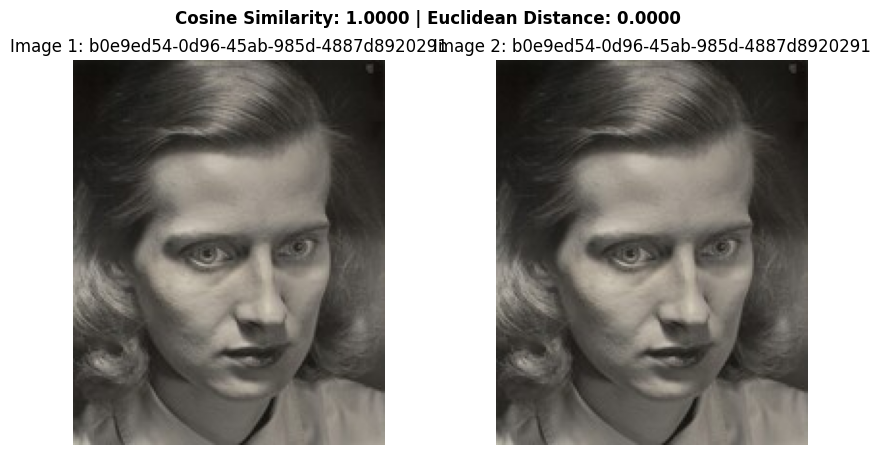

In [ ]:
import numpy as np
import pandas as pd
import random
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Load saved image features
image_features = np.load("image_features.npy", allow_pickle=True).item()

# Load dataset (replace 'your_dataset.csv' with actual path)
df = pd.read_csv(data_path)  # Replace with actual path

# Take a random 5% sample (to match feature extraction process)
df = df.sample(frac=0.05).reset_index(drop=True)

# Get all available image IDs that have extracted features
available_images = df[df['uuid'].isin(image_features.keys())]

# Ensure there are at least two images
if len(available_images) < 2:
    print("Not enough images with extracted features to compare.")
else:
    # Randomly select two image IDs
    selected_images = available_images.sample(2, random_state=42)  # Select 2 random images
    # image_id_1, image_id_2 = selected_images['uuid'].values
    # image_url_1, image_url_2 = selected_images['iiifthumburl'].values  # Get image URLs
    # image_id_1 = '5a0d5e53-5230-4159-bda4-e85a04d168df'
    # image_url_1 = 'https://api.nga.gov/iiif/5a0d5e53-5230-4159-bda4-e85a04d168df/full/!200,200/0/default.jpg'
    image_id_1 = 'b0e9ed54-0d96-45ab-985d-4887d8920291'
    image_url_1 = 'https://api.nga.gov/iiif/b0e9ed54-0d96-45ab-985d-4887d8920291/full/!200,200/0/default.jpg'
    image_id_2 = 'b0e9ed54-0d96-45ab-985d-4887d8920291'
    image_url_2 = 'https://api.nga.gov/iiif/b0e9ed54-0d96-45ab-985d-4887d8920291/full/!200,200/0/default.jpg'
    # Retrieve their features
    features_1 = image_features[image_id_1].reshape(1, -1)
    features_2 = image_features[image_id_2].reshape(1, -1)

    # Compute Cosine Similarity (higher means more similar)
    similarity = cosine_similarity(features_1, features_2)[0][0]

    # Compute Euclidean Distance (lower means more similar)
    euclidean_distance = np.linalg.norm(features_1 - features_2)

    # Download and open the images
    response_1 = requests.get(image_url_1)
    response_2 = requests.get(image_url_2)
    image_1 = Image.open(BytesIO(response_1.content))
    image_2 = Image.open(BytesIO(response_2.content))

    # Plot images side-by-side with similarity scores
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image_1)
    axes[0].axis('off')
    axes[0].set_title(f"Image 1: {image_id_1}")

    axes[1].imshow(image_2)
    axes[1].axis('off')
    axes[1].set_title(f"Image 2: {image_id_2}")

    # Add similarity metrics as a title
    plt.suptitle(f"Cosine Similarity: {similarity:.4f} | Euclidean Distance: {euclidean_distance:.4f}", fontsize=12, fontweight='bold')
    print(f"image id 1: {image_id_1} image_id_2 : {image_id_2}")
    print(f"image id 1: {image_url_1} image_id_2 : {image_url_2}")

    plt.show()


In [ ]:
68ea9c63-6b30-41d0-bbac-ec6db21bc9fb
https://api.nga.gov/iiif/68ea9c63-6b30-41d0-bbac-ec6db21bc9fb/full/!200,200/0/default.jpg

In [ ]:
5a0d5e53-5230-4159-bda4-e85a04d168df
 https://api.nga.gov/iiif/5a0d5e53-5230-4159-bda4-e85a04d168df/full/!200,200/0/default.jpg

In [ ]:
image_id_1 = 'd41e6b2a-980d-450b-bc65-404941bf53e1'
image_url_1 = 'https://api.nga.gov/iiif/d41e6b2a-980d-450b-bc65-404941bf53e1/full/!200,200/0/default.jpg'

In [ ]:
b0e9ed54-0d96-45ab-985d-4887d8920291
https://api.nga.gov/iiif/b0e9ed54-0d96-45ab-985d-4887d8920291/full/!200,200/0/default.jpg

In [ ]:
d57307be-f4a4-4ee4-a7c7-8d2fa6a91010
https://api.nga.gov/iiif/d57307be-f4a4-4ee4-a7c7-8d2fa6a91010/full/!200,200/0/default.jpg

In [ ]:
image_id_2 = 'b0e9ed54-0d96-45ab-985d-4887d8920291'

image_url_2 = 'https://api.nga.gov/iiif/b0e9ed54-0d96-45ab-985d-4887d8920291/full/!200,200/0/default.jpg'

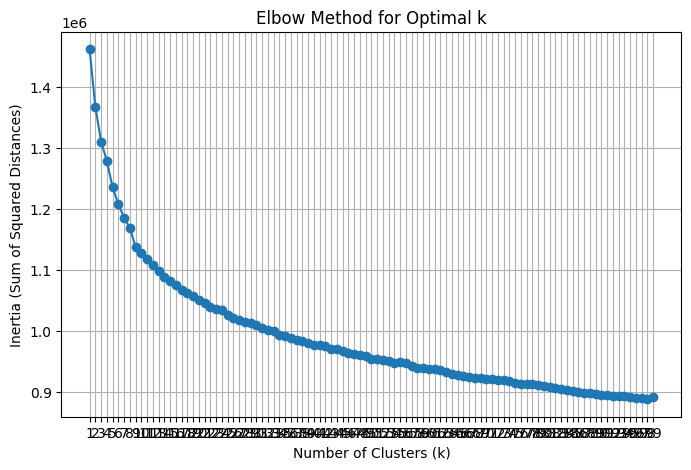

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load saved image features
image_features = np.load("image_features.npy", allow_pickle=True).item()
X = np.array(list(image_features.values()))  # Convert to array

# Try different k values
inertia_values = []
k_values = range(1, 100)  # Try k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)  # Store inertia (sum of squared distances)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

best_k = 2  # Start from 2 (since k=1 has no separation)
best_score = -1

for k in range(2, 100):  # Try different k values
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)  # Compute silhouette score

    print(f"k={k}, Silhouette Score={score:.4f}")

    if score > best_score:
        best_k = k
        best_score = score

print(f"\nOptimal Number of Clusters: {best_k}")


k=2, Silhouette Score=0.0766
k=3, Silhouette Score=0.0499
k=4, Silhouette Score=0.0315
k=5, Silhouette Score=0.0495
k=6, Silhouette Score=0.0550
k=7, Silhouette Score=0.0486
k=8, Silhouette Score=0.0399
k=9, Silhouette Score=0.0494
k=10, Silhouette Score=0.0482
k=11, Silhouette Score=0.0374
k=12, Silhouette Score=0.0387
k=13, Silhouette Score=0.0398
k=14, Silhouette Score=0.0377
k=15, Silhouette Score=0.0370
k=16, Silhouette Score=0.0380
k=17, Silhouette Score=0.0375
k=18, Silhouette Score=0.0378
k=19, Silhouette Score=0.0358
k=20, Silhouette Score=0.0368
k=21, Silhouette Score=0.0347
k=22, Silhouette Score=0.0363
k=23, Silhouette Score=0.0333
k=24, Silhouette Score=0.0341
k=25, Silhouette Score=0.0337
k=26, Silhouette Score=0.0329
k=27, Silhouette Score=0.0296
k=28, Silhouette Score=0.0275
k=29, Silhouette Score=0.0278
k=30, Silhouette Score=0.0266
k=31, Silhouette Score=0.0274
k=32, Silhouette Score=0.0287
k=33, Silhouette Score=0.0293
k=34, Silhouette Score=0.0302
k=35, Silhouette S

## Agglomerative Hierarchical Clustering (Recommended)

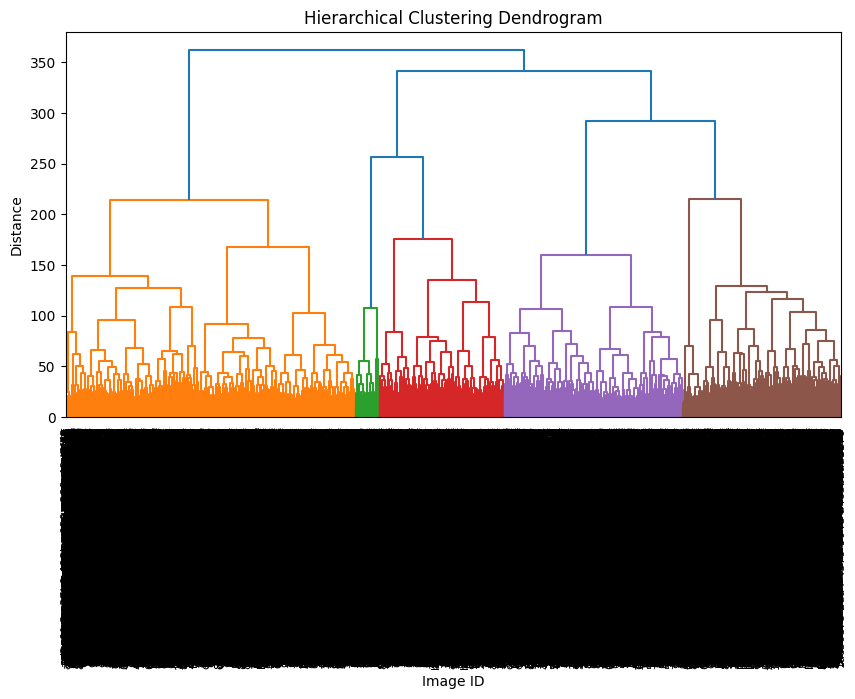

Image ID: 59109304-8e31-40a7-959e-0bf299fe05b2, Cluster: 2
Image ID: eab3ba18-a5bc-46d3-a605-c143b12811fb, Cluster: 2
Image ID: cda121bd-ba95-475d-af5b-62abba3f1956, Cluster: 1
Image ID: 90bcfcdf-7ba1-45c1-bcfd-7e1ca794b2e5, Cluster: 2
Image ID: e377973b-c6aa-465d-a7f5-e8f09dd2fbad, Cluster: 1
Image ID: 0db6a198-91d5-4f82-bf76-5f65dfc746ca, Cluster: 2
Image ID: a62a8953-8b78-4922-a1e3-3b1665555794, Cluster: 2
Image ID: 01aa1db1-770c-4a99-b547-fdfe5c19bad4, Cluster: 2
Image ID: c7872b3a-6d88-4718-bac3-b52fa6278d73, Cluster: 2
Image ID: 1973a54a-daa1-4f62-aafc-0755b78727f2, Cluster: 2
Image ID: c765890a-2bc5-405d-8033-e872ec4aabcf, Cluster: 2
Image ID: e32811c7-6c56-4f37-abf2-bfcd8a012177, Cluster: 2
Image ID: 24f23844-ef30-449b-9822-d4255682630b, Cluster: 1
Image ID: a6950a9a-06f1-4348-ad57-d568802a6f38, Cluster: 2
Image ID: e2b2e753-547f-4b9f-9414-79e98ce0567c, Cluster: 1
Image ID: c6977832-7d94-429b-a281-61cd96226b3a, Cluster: 2
Image ID: 3995b11b-2647-4e5b-a766-678c607dc833, Cluster:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Load saved image features
image_features = np.load("image_features.npy", allow_pickle=True).item()
X = np.array(list(image_features.values()))  # Convert dictionary values to array
image_ids = list(image_features.keys())  # Get image IDs

# Perform Hierarchical Clustering
Z = linkage(X, method="ward")  # 'ward' minimizes variance within clusters

# Plot Dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=image_ids, leaf_rotation=90, leaf_font_size=8)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Image ID")
plt.ylabel("Distance")
plt.show()

# Decide number of clusters (e.g., cut at 2 clusters)
num_clusters = 2
clusters = fcluster(Z, num_clusters, criterion="maxclust")

# Print Clustering Results
for img_id, cluster in zip(image_ids, clusters):
    print(f"Image ID: {img_id}, Cluster: {cluster}")


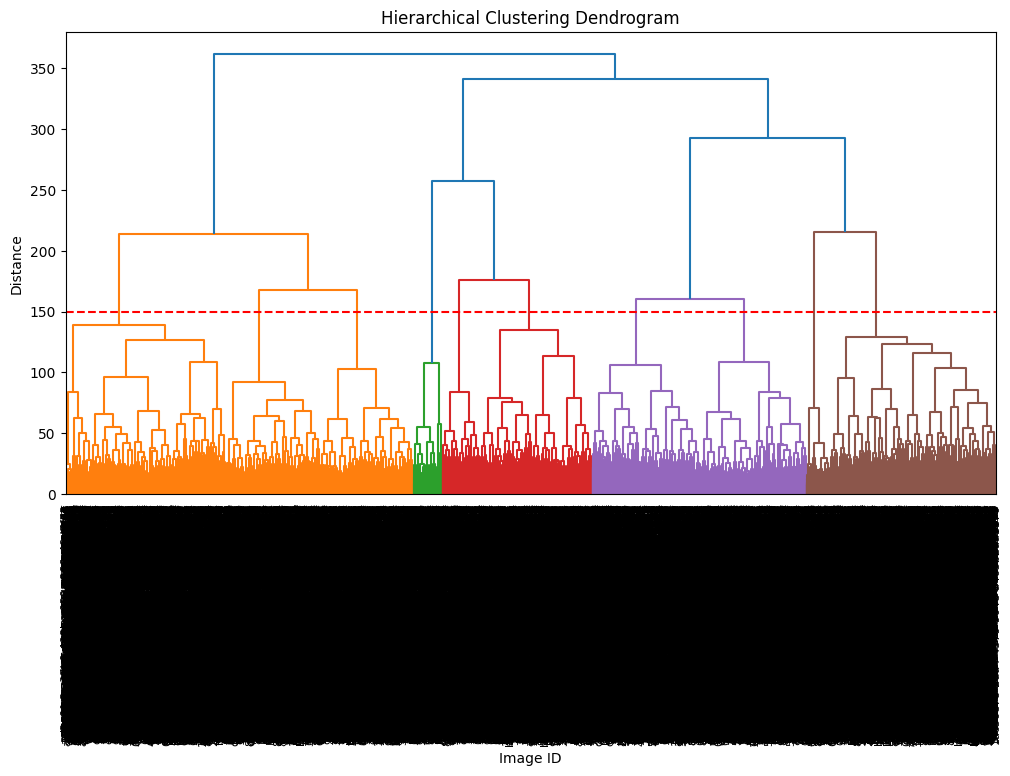

Image ID: 59109304-8e31-40a7-959e-0bf299fe05b2, Cluster: 3
Image ID: eab3ba18-a5bc-46d3-a605-c143b12811fb, Cluster: 3
Image ID: cda121bd-ba95-475d-af5b-62abba3f1956, Cluster: 1
Image ID: 90bcfcdf-7ba1-45c1-bcfd-7e1ca794b2e5, Cluster: 2
Image ID: e377973b-c6aa-465d-a7f5-e8f09dd2fbad, Cluster: 1
Image ID: 0db6a198-91d5-4f82-bf76-5f65dfc746ca, Cluster: 3
Image ID: a62a8953-8b78-4922-a1e3-3b1665555794, Cluster: 2
Image ID: 01aa1db1-770c-4a99-b547-fdfe5c19bad4, Cluster: 3
Image ID: c7872b3a-6d88-4718-bac3-b52fa6278d73, Cluster: 3
Image ID: 1973a54a-daa1-4f62-aafc-0755b78727f2, Cluster: 3
Image ID: c765890a-2bc5-405d-8033-e872ec4aabcf, Cluster: 3
Image ID: e32811c7-6c56-4f37-abf2-bfcd8a012177, Cluster: 3
Image ID: 24f23844-ef30-449b-9822-d4255682630b, Cluster: 1
Image ID: a6950a9a-06f1-4348-ad57-d568802a6f38, Cluster: 3
Image ID: e2b2e753-547f-4b9f-9414-79e98ce0567c, Cluster: 1
Image ID: c6977832-7d94-429b-a281-61cd96226b3a, Cluster: 3
Image ID: 3995b11b-2647-4e5b-a766-678c607dc833, Cluster:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Load saved image features
image_features = np.load("image_features.npy", allow_pickle=True).item()
X = np.array(list(image_features.values()))  # Convert dictionary values to array
image_ids = list(image_features.keys())  # Get image IDs

# Perform Hierarchical Clustering
Z = linkage(X, method="ward")  # 'ward' minimizes variance within clusters

# Plot Dendrogram with threshold line
plt.figure(figsize=(12, 6))
dendrogram(Z, labels=image_ids, leaf_rotation=90, leaf_font_size=8)
plt.axhline(y=150, color='r', linestyle='--')  # Adjust threshold line manually
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Image ID")
plt.ylabel("Distance")
plt.show()

# Choose clusters based on the dendrogram gap
optimal_clusters = 3  # Set based on the largest vertical gap in the dendrogram
clusters = fcluster(Z, optimal_clusters, criterion="maxclust")

# Print Clustering Results
for img_id, cluster in zip(image_ids, clusters):
    print(f"Image ID: {img_id}, Cluster: {cluster}")


🔹 Image 1: 04570b01-f9de-42cb-97ff-d33abe5a9051
   Predicted Cluster: 2


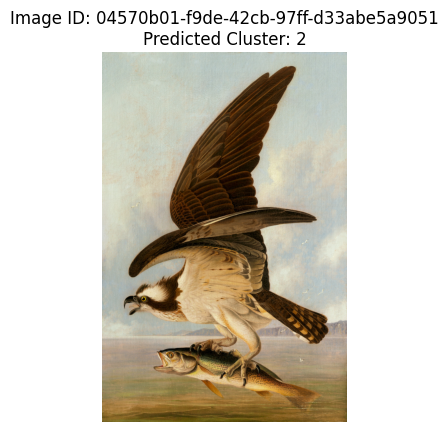

🔹 Image 2: efdc3da1-4b93-4b4d-8611-daa5efc3485d
   Predicted Cluster: 2
Error loading image from URL: 503 Server Error: Service Unavailable for url: https://api.nga.gov/iiif/efdc3da1-4b93-4b4d-8611-daa5efc3485d/full/full/0/default.jpg
🔹 Image 3: 413c6100-0b95-4a2e-819a-d15ceceae0b7
   Predicted Cluster: 3


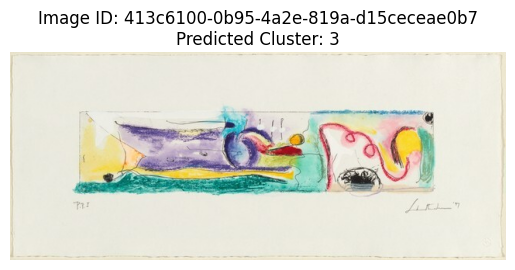

🔹 Image 4: 4d2b0215-a7ee-491f-b0ad-301fb4d5663e
   Predicted Cluster: 1


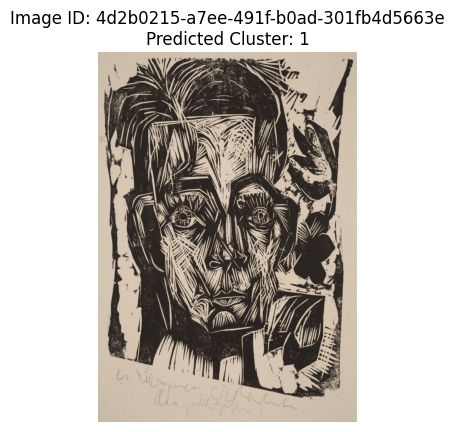

🔹 Image 5: 899166e7-4f26-429c-a6c2-8a9e622a57a4
   Predicted Cluster: 1


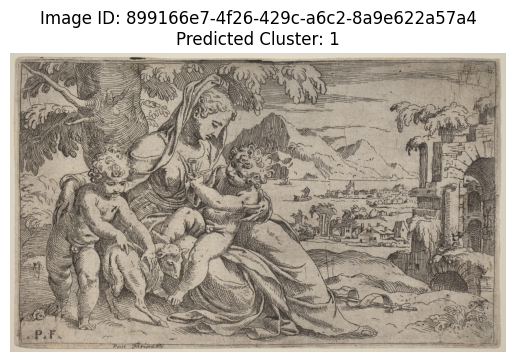

🔹 Image 6: 035d4018-e52f-41c1-b359-34b6253274a0
   Predicted Cluster: 1


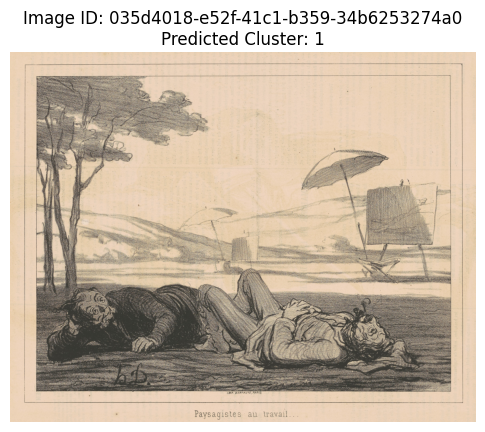

🔹 Image 7: b512fefe-c6b2-469a-b633-777133ed4501
   Predicted Cluster: 1
Error loading image from URL: 503 Server Error: Service Unavailable for url: https://api.nga.gov/iiif/b512fefe-c6b2-469a-b633-777133ed4501/full/full/0/default.jpg
🔹 Image 8: bfd31b40-ffe3-45c2-893a-ce4ea37b8143
   Predicted Cluster: 3


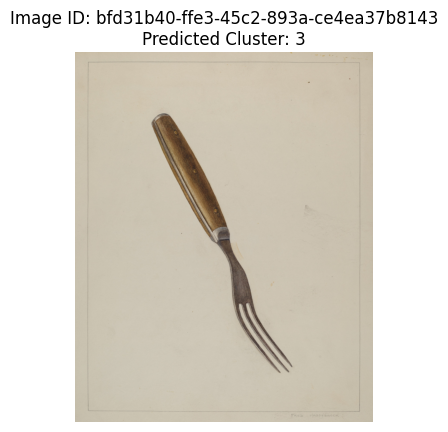

🔹 Image 9: c4bc6ec3-1da8-4b46-a397-62d26fb940a8
   Predicted Cluster: 1


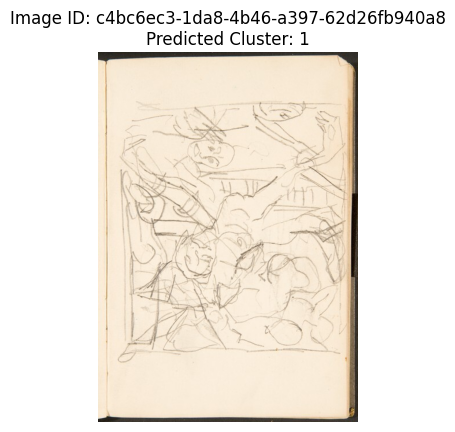

🔹 Image 10: 0bda97e4-d565-4e7c-8903-9b3d289cc8de
   Predicted Cluster: 1


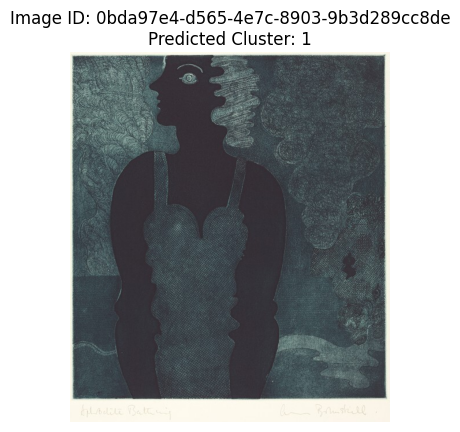

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from PIL import Image
import pandas as pd
import requests
from io import BytesIO
import random

# Load saved image features
image_features = np.load("image_features.npy", allow_pickle=True).item()
X = np.array(list(image_features.values()))  # Convert dictionary values to array
image_ids = list(image_features.keys())  # Get image IDs

# Load dataset (assuming it contains 'uuid' and 'iiifurl' columns)
# Replace with actual dataset path
df = pd.read_csv(data_path)
image_path_mapping = dict(zip(df["uuid"], df["iiifurl"]))  # Map UUID to image URLs

# Perform Hierarchical Clustering
Z = linkage(X, method="ward")  # 'ward' minimizes variance within clusters

# Determine optimal cluster count using the largest gap
distances = Z[:, 2]  # Extract merge distances
jumps = np.diff(distances)
optimal_threshold = distances[np.argmax(jumps)]  # Cut at the largest jump

# Assign clusters
clusters = fcluster(Z, optimal_threshold, criterion="distance")

# Create a mapping of image IDs to clusters
cluster_mapping = {img_id: cluster for img_id, cluster in zip(image_ids, clusters)}

# Convert clusters to cluster centroids (average of points in each cluster)
unique_clusters = np.unique(clusters)
cluster_centroids = {
    cluster: np.mean(X[np.array(clusters) == cluster], axis=0)
    for cluster in unique_clusters
}

# 🔹 Function to Predict the Cluster for a New Image
def predict_cluster(new_image_feature):
    new_image_feature = np.array(new_image_feature).reshape(1, -1)
    cluster_distances = {cluster: np.linalg.norm(new_image_feature - centroid) for cluster, centroid in cluster_centroids.items()}
    predicted_cluster = min(cluster_distances, key=cluster_distances.get)  # Closest cluster
    return predicted_cluster

# 🔹 Function to Display an Image from IIIF URL
def display_image(image_id, predicted_cluster):
    base_url = image_path_mapping.get(image_id, None)
    if base_url:
        # Append IIIF parameters for a valid image request
        image_url = f"{base_url}/full/full/0/default.jpg"
        try:
            response = requests.get(image_url)
            response.raise_for_status()  # Ensure we got a valid response
            img = Image.open(BytesIO(response.content))  # Load image from URL
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Image ID: {image_id}\nPredicted Cluster: {predicted_cluster}")
            plt.show()
        except requests.exceptions.RequestException as e:
            print(f"Error loading image from URL: {e}")
        except Image.UnidentifiedImageError:
            print(f"Could not identify image for {image_id}. Check the IIIF URL format.")
    else:
        print(f"Image URL for {image_id} not found!")

# 🔹 Select 10 Random Images from Dataset
random_image_ids = random.sample(image_ids, 10)  # Pick 10 random images

# 🔹 Loop through the images, predict clusters, and display them
for idx, image_id in enumerate(random_image_ids, start=1):
    image_feature = image_features[image_id]  # Get its feature vector
    predicted_cluster = predict_cluster(image_feature)  # Predict cluster

    print(f"🔹 Image {idx}: {image_id}")
    print(f"   Predicted Cluster: {predicted_cluster}")

    # Display the image
    display_image(image_id, predicted_cluster)


cluster 1 line painting
cluster 2 smooth painting
cluster 3 object painting